In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

#archive = h5py.File('/Volumes/tycho/stash/archive.hdf5', 'r')
# dset = archive['2018.01.21']

In [10]:
#photometry = archive['photometry'][:]

photometry = np.load('photometry.npy')
photometry_err = np.load('photometry_err.npy')
#photometry = photometry[photometry != 0]
#photometry_err = np.sqrt(photometry)
#photometry_err /= photometry.mean()
#photometry = photometry/photometry.mean()


#np.save('photometry.npy', photometry)
#np.save('photometry_err.npy', photometry_err)

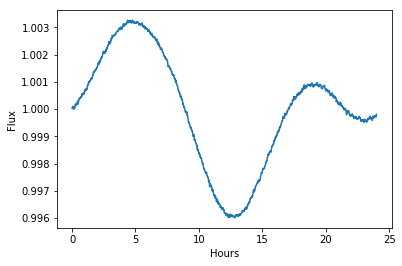

In [11]:
t = 45 * np.arange(len(photometry))
plt.errorbar(t/60/60, photometry, photometry_err)
plt.xlabel('Hours')
plt.ylabel('Flux')
plt.savefig('paper_plots/sys.png', bbox_inches='tight')

In [12]:
# def func(p):
#     period, amp, phase, offset = p
#     return offset + amp * np.sin(2*np.pi * t/60/60/period - phase)

# def minimize(p, yerr=1e-4):
#     return np.sum((photometry - func(p))**2 / yerr**2)

# # plt.plot(t/60/60, mean + 1e-3 * np.sin(2*np.pi * t/60/60/12 - np.pi/2))

# from scipy.optimize import fmin_powell

# bestp = fmin_powell(minimize, [12, 1e-3, np.pi/2, np.mean(photometry)])

# plt.plot(t/60/60, photometry/func(bestp) - 1)

In [13]:
import celerite
from celerite import terms

bounds = dict(log_sigma=(-15, 15), log_rho=(-15, 0))
kernel = terms.Matern32Term(log_sigma=0, log_rho=-1)

x, y, yerr = t/60/60, photometry-np.mean(photometry), 100*photometry_err
gp = celerite.GP(kernel)
gp.compute(x, yerr)

In [14]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -15169.019440127779
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.09349606,  0.07894414])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 117
      nit: 16
   status: 0
  success: True
        x: array([-5.52831222,  2.65913539])


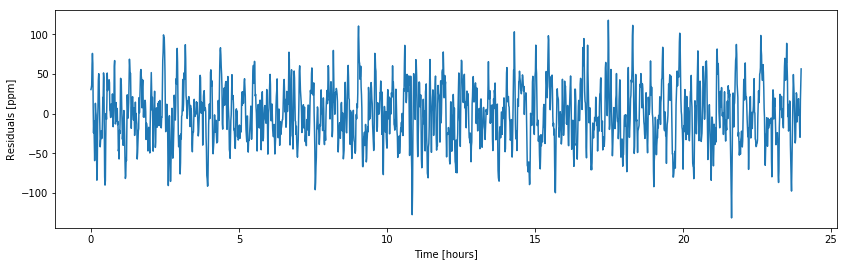

In [15]:
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)
plt.figure(figsize=(14, 4))
plt.plot(x, 1e6*(y - pred_mean))
plt.xlabel('Time [hours]')
plt.ylabel('Residuals [ppm]')
plt.savefig('flicker.png', bbox_inches='tight', dpi=250)

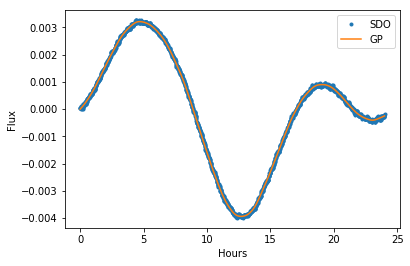

In [16]:
plt.plot(x, y, '.', label='SDO')
plt.plot(x, pred_mean, label='GP')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Flux')
plt.savefig('paper_plots/diurnal_signal.png', dpi=350, bbox_inches='tight')

In [17]:
# from gatspy.periodic import LombScargleFast

# m = LombScargleFast()
# m.fit(x, pred_mean)
# periods = np.linspace(0.01, 30, 1000)
# scores = m.score(periods)
# fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# ax[0].plot(periods, scores)

# ax[1].plot(periods, scores)
# ax[1].set_xlim([0, 10])
# ax[1].set_ylim([0, 0.05])
# for axis in ax: 
#     axis.set_ylabel('LS Power')
#     axis.set_xlabel('Period [hours]')
# ax[1].set_title('Zoom into short periods')
# plt.savefig('paper_plots/ls.pdf', bbox_inches='tight')

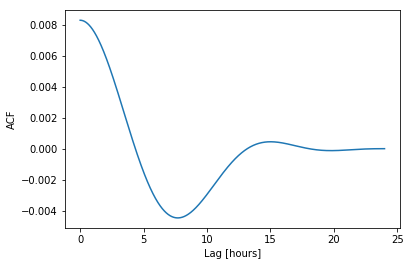

In [18]:
from interpacf import interpolated_acf

lags, acf = interpolated_acf(x, pred_mean)

plt.plot(lags, acf)
plt.xlabel('Lag [hours]')
plt.ylabel('ACF')
plt.savefig('paper_plots/acf.pdf', bbox_inches='tight')

In [19]:
np.save('detrended_photometry.npy', y-pred_mean)

In [20]:
# from interpacf import interpolated_acf

# lags, acf = interpolated_acf(x, y-pred_mean)

# plt.plot(lags, acf/acf.max())
# plt.ylim([-0.2, 0.2])
# plt.xlim([0, 1])

      fun: -16230.869796134111
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 54903.19381352, 189296.89467768])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 282
      nit: 4
   status: 2
  success: False
        x: array([-1.24935055, -1.96841329])


Text(0,0.5,'Residuals [ppm]')

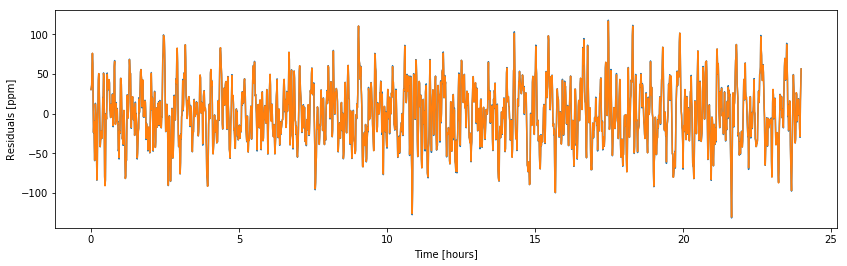

In [83]:
# class CustomTerm(terms.Term):
#     """Decaying exponential"""
#     parameter_names = ("log_a", "log_c", "log_P")

#     def get_complex_coefficients(self):#, params):
#         #log_a, log_c, log_P = self.params
#         return (
#             np.exp(self.log_a), 0,
#             np.exp(self.log_c), 2*np.pi*np.exp(-self.log_P),
#         )

# bounds = dict(log_a=(-50, 15), log_c=(-10, 10), log_P=(-15, 0))
# kernel = CustomTerm(log_a=-1, log_c=0, log_P=-1, bounds=bounds)

bounds = dict(log_S0=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=-1, log_omega0=-1, log_Q=1/np.sqrt(2))
kernel.freeze_parameter('log_Q')

gp = celerite.GP(kernel)
gp.compute(x, photometry_err)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y-pred_mean)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y-pred_mean, gp))
gp.set_parameter_vector(r.x)
print(r)

model = gp.predict(y-pred_mean, x, return_var=False)[0]
plt.figure(figsize=(14, 4))
plt.plot(x, 1e6*(y-pred_mean))
plt.plot(x, 1e6*model)
plt.xlabel('Time [hours]')
plt.ylabel('Residuals [ppm]')
# plt.savefig('flicker.png', bbox_inches='tight', dpi=250)

<ErrorbarContainer object of 3 artists>

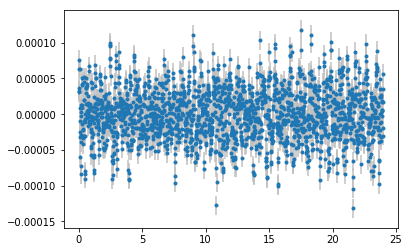

In [84]:
plt.errorbar(x, y-pred_mean, 10*photometry_err, ecolor='silver', fmt='.')

Text(0.5,0,'Lags [min]')

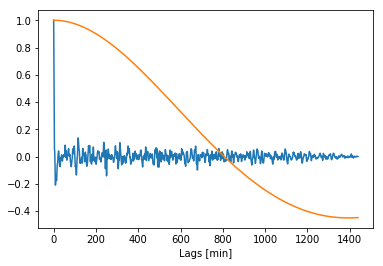

In [85]:
from interpacf import interpolated_acf

lags, acf = interpolated_acf(x, y-pred_mean)

plt.plot(lags * 60, acf/acf.max())

plt.plot(lags * 60, gp.kernel.get_value(lags)/gp.kernel.get_value(lags).max())
# plt.ylim([-0.2, 0.2])
# plt.xlim([0, 100])
plt.xlabel('Lags [min]')

In [86]:
# nwalkers, ndim = 20, 3

nwalkers, ndim = 20, 2

import emcee

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y-pred_mean) + lp


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

initp = [np.array([-1, -1])#np.array([-20, 2.7, -1])
         + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]

print('burn in...')
p0 = sampler.run_mcmc(initp, 10000)[0]
sampler.reset()
print('production...')
sampler.run_mcmc(p0, 5000);
sampler.pool.close()

burn in...
production...


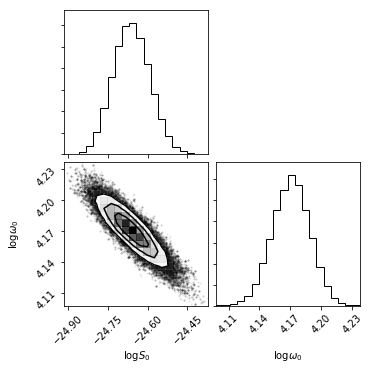

In [87]:
from corner import corner

#corner(sampler.flatchain, labels=['$\log a$', '$\log c$', '$\log P$']);
corner(sampler.flatchain, labels=['$\log S_0$', '$\log \omega_0$']);
plt.savefig('paper_plots/flicker_corner.pdf', bbox_inches='tight')

In [93]:
2*np.pi / np.exp(sampler.flatchain[:, 1].mean()) * 60

5.823041708301464

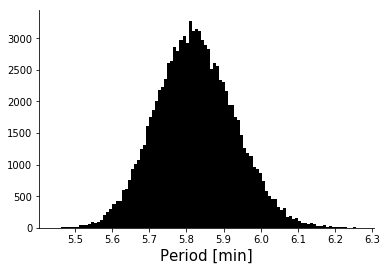

In [95]:
plt.hist(2*np.pi/np.exp(sampler.flatchain[:, 1]) * 60, bins=100, histtype='stepfilled', color='k')
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.xlabel('Period [min]', fontsize=15)
plt.savefig('paper_plots/period.pdf', bbox_inches='tight')

In [99]:
np.median(2 * np.pi / np.exp(sampler.flatchain[:, -1])) *60, np.std(2 * np.pi / np.exp(sampler.flatchain[:, -1])) *60,

(5.821209125717098, 0.10607918696591447)

In [100]:
gp.kernel.set_parameter_vector(np.median(sampler.flatchain, axis=0))

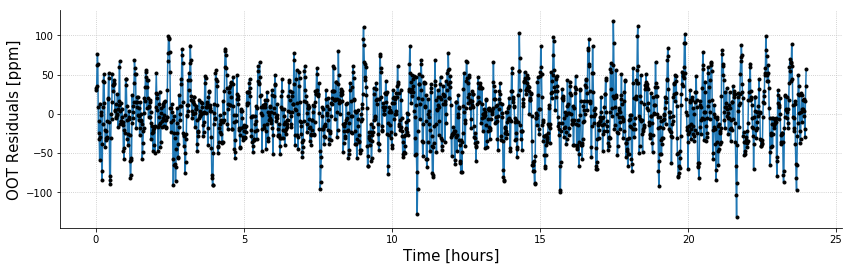

In [101]:
model = gp.predict(y - pred_mean, x, return_cov=False)

plt.figure(figsize=(14, 4))
plt.errorbar(x, 1e6*(y-pred_mean), 1e6*photometry_err, ecolor='silver', fmt='.', color='k')
plt.plot(x, 1e6*model)

fontsize = 15
plt.xlabel('Time [hours]', fontsize=fontsize)
plt.ylabel('OOT Residuals [ppm]', fontsize=fontsize)

for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(ls=':', color='silver')
plt.savefig('paper_plots/flicker_gp.pdf', bbox_inches='tight', dpi=250)

In [38]:
from astropy.constants import R_earth, R_sun
from batman import TransitParams, TransitModel
import astropy.units as u
import numpy as np

params = TransitParams()
params.per = 365
params.rp = float(R_earth/R_sun)
params.a = float(1*u.AU/R_sun)
params.inc = 89.9

# Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
params.u = [0.45, 0.19]
params.limb_dark = "quadratic"

params.ecc = 0
params.w = np.pi/2
params.t0 = 0

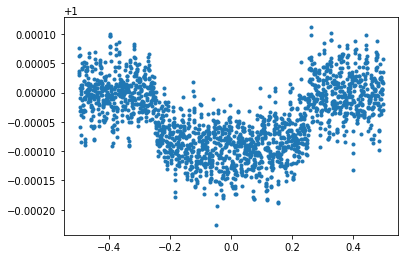

burn in...
production...


In [121]:
import emcee
import batman 
from copy import deepcopy
import celerite
from celerite import terms
from celerite.modeling import Model

# class CustomTerm(terms.Term):
#     """Decaying exponential"""
#     parameter_names = ("log_a", "log_c", "log_P")

#     def get_complex_coefficients(self):
#         return (
#             np.exp(self.log_a), 0,
#             np.exp(self.log_c), 2*np.pi*np.exp(-self.log_P),
#         )

class MeanModel(Model):
    parameter_names = 'rp, inc, a, t0, u1, u2'.split(', ')

    def get_value(self, t):
        trial_params = deepcopy(params)
        trial_params.rp = self.rp
        trial_params.inc = self.inc
        trial_params.t0 = self.t0
        trial_params.a = self.a
        trial_params.u = [self.u1, self.u2]

        m = batman.TransitModel(trial_params, t)
        return m.light_curve(trial_params)


m = batman.TransitModel(params, (x-x.mean())/24)
transit_model = m.light_curve(params)

injected_transit = y - pred_mean + transit_model

plt.plot((x-x.mean())/24, injected_transit, '.')
plt.show()

# bounds = dict(log_a=(-50, 15), log_c=(-10, 10), log_P=(np.log((x[1]-x[0])/24), 0))
# kernel = CustomTerm(log_a=-20, log_c=2.7, log_P=-1.6, bounds=bounds)
bounds = dict(log_S0=(-30, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=-24.5, log_omega0=4.17, log_Q=1/np.sqrt(2))
kernel.freeze_parameter('log_Q')


mean_model = mean=MeanModel(rp=params.rp, t0=params.t0, inc=params.inc, a=params.a,
                            u1=params.u[0], u2=params.u[1],  
                            bounds=dict(rp=(0, 1.2*float(R_earth/R_sun)), t0=(-0.01, 0.01), 
                                        u1=(-1, 1), u2=(-1, 1), inc=(0, 90), a=(100, 300)))


gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute((x-x.mean())/24, yerr=photometry_err)


def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(injected_transit) + lp


nwalkers, ndim = 50, 8

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)

initp = [np.array([-28, 7.3, params.rp, params.inc, params.a, params.t0, params.u[0], params.u[1]]) 
         #np.array([-20, 6, -5, params.rp, params.inc, params.a, params.t0, params.u[0], params.u[1]])
         + 1e-5 * np.random.randn(ndim) for _ in range(nwalkers)]

print('burn in...')
p0 = sampler.run_mcmc(initp, 10000)[0]
sampler.reset()
print('production...')
sampler.run_mcmc(p0, 5000);

In [122]:
sampler.pool.close()

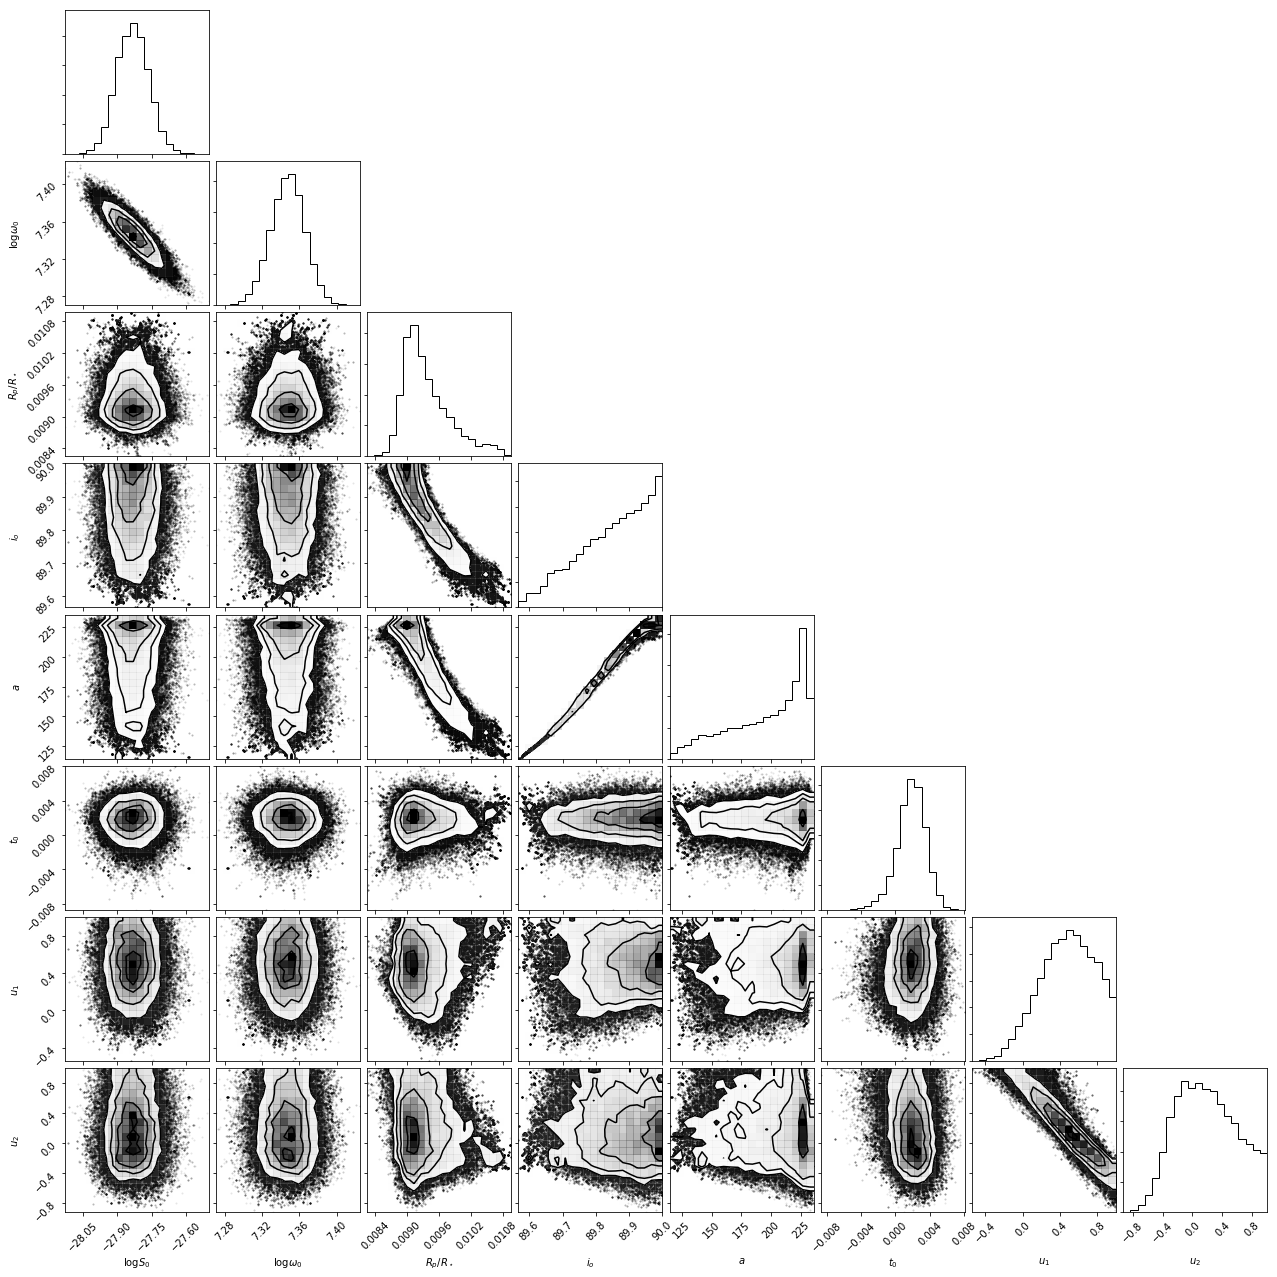

In [123]:
from corner import corner

corner(sampler.flatchain, labels=["${0}$".format(i) for i in "\log S_0,\log \omega_0,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
                                  #"\log a,\log c,\log P,R_p/R_\star,i_o,a,t_0,u_1,u_2".split(',')]);
plt.savefig("paper_plots/corner_oot.pdf", bbox_inches='tight')
plt.show()

0.04803389642893902

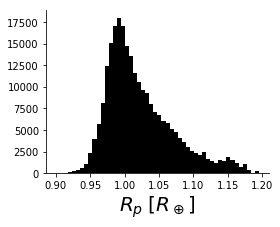

In [125]:
from astropy.constants import R_sun, R_earth

plt.figure(figsize=(4, 3))
plt.hist(sampler.flatchain[:, 2] / (R_earth/R_sun), bins=50, color='k', histtype='stepfilled')#, range=[0.8, 1.2]);
plt.xlabel("$R_p \; [R_\oplus]$", fontsize=20)
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.savefig('paper_plots/radius_posterior.pdf', bbox_inches='tight')
sampler.flatchain[:, 2].std() / sampler.flatchain[:, 2].mean()

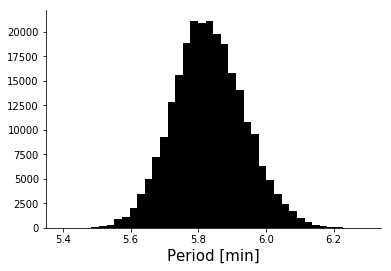

In [126]:
plt.hist(2*np.pi / np.exp(sampler.flatchain[:, 1]) * 24 * 60, bins=40, histtype='stepfilled', color='k')#, range=[5, 7])
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.xlabel('Period [min]', fontsize=15)
plt.savefig('paper_plots/flicker_period.pdf', bbox_inches='tight')